<a href="https://colab.research.google.com/github/GustGon/I.A.Python/blob/master/neural-network/nn-recurrent/BOVESPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
# TensorFlow e tf.keras

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
print(tf.__version__)

2.0.0


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Imports de biblioteca
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [0]:
#Carregar dataset
dataset = pd.read_csv('/content/drive/My Drive/BOVESPA.csv',index_col='DATE', parse_dates=['DATE'])
dataset.head()

,CODBDI,CODNEG,DATVEN,FATCOT,NOMRES,PRAZOT,PREABE,PREEXE,PREMAX,PREMED,PREMIN,PREOFC,PREOFV,PREULT,PTOEXE,QUATOT,TOTNEG,TPMERC,VOLTOT
DATE,,,,,,,,,,,,,,,,,,,
1995-01-02,2,ACE 3,99991231,1000,ACESITA,NaN,63.00,0.0,63.00,63.00,63.00,63.0,65.00,63.00,0.0,200000,1,10,12600.0
1995-01-02,2,ACE 4,99991231,1000,ACESITA,NaN,73.00,0.0,73.00,72.71,72.00,71.5,73.00,72.00,0.0,5300000,5,10,385400.0
1995-01-02,2,ALP 4,99991231,1000,ALPARGATAS,NaN,160.00,0.0,165.00,160.03,160.00,156.0,0.00,160.00,0.0,1610000,11,10,257652.0
1995-01-02,2,ROS 4,99991231,1000,AMADEO ROSSI,NaN,1.85,0.0,1.85,1.85,1.85,1.7,1.84,1.85,0.0,300000,1,10,555.0
1995-01-02,2,BAS 4,99991231,1000,AMERICA SUL,NaN,48.00,0.0,48.00,48.00,48.00,0.0,51.50,48.00,0.0,15000,1,10,720.0


In [0]:
dataset.shape

(6394425, 19)

In [0]:
dataset.isnull().sum()

CODBDI          0
CODNEG          0
DATVEN          0
FATCOT          0
NOMRES          4
PRAZOT    3253834
PREABE          0
PREEXE          0
PREMAX          0
PREMED          0
PREMIN          0
PREOFC          0
PREOFV          0
PREULT          0
PTOEXE          0
QUATOT          0
TOTNEG          0
TPMERC          0
VOLTOT          0
dtype: int64

In [0]:
ds_emp = dataset[(dataset['CODNEG'] == 'BRKM5F') & (dataset['CODBDI'] == 96)]
ds_emp.tail()

,CODBDI,CODNEG,DATVEN,FATCOT,NOMRES,PRAZOT,PREABE,PREEXE,PREMAX,PREMED,PREMIN,PREOFC,PREOFV,PREULT,PTOEXE,QUATOT,TOTNEG,TPMERC,VOLTOT
DATE,,,,,,,,,,,,,,,,,,,
2019-09-25,96,BRKM5F,99991231,1,BRASKEM,NaN,32.17,0.0,32.55,32.11,31.78,32.39,32.40,32.40,0.0,7801,383,20,250523.90
2019-09-26,96,BRKM5F,99991231,1,BRASKEM,NaN,32.59,0.0,33.02,32.59,32.20,32.21,32.38,32.38,0.0,9556,520,20,311519.13
2019-09-27,96,BRKM5F,99991231,1,BRASKEM,NaN,32.93,0.0,32.93,32.70,32.43,32.43,32.60,32.43,0.0,8254,448,20,269932.90
2019-09-30,96,BRKM5F,99991231,1,BRASKEM,NaN,32.96,0.0,32.96,32.36,31.92,32.50,32.56,32.56,0.0,9059,516,20,293186.82
2019-10-01,96,BRKM5F,99991231,1,BRASKEM,NaN,32.70,0.0,32.70,32.04,31.52,31.61,31.70,31.70,0.0,9196,585,20,294663.69


In [0]:
ds_emp = dataset[(dataset['CODNEG'] == 'BRKM5F') & (dataset['CODBDI'] == 96)]
df_filtrado = ds_emp[['CODBDI', 'CODNEG', 'NOMRES', 'PREMAX', 'PREMED', 'PREMIN', 'PREULT', 'VOLTOT']]
df_filtrado.tail()

,CODBDI,CODNEG,NOMRES,PREMAX,PREMED,PREMIN,PREULT,VOLTOT
DATE,,,,,,,,
2019-09-25,96,BRKM5F,BRASKEM,32.55,32.11,31.78,32.40,250523.90
2019-09-26,96,BRKM5F,BRASKEM,33.02,32.59,32.20,32.38,311519.13
2019-09-27,96,BRKM5F,BRASKEM,32.93,32.70,32.43,32.43,269932.90
2019-09-30,96,BRKM5F,BRASKEM,32.96,32.36,31.92,32.56,293186.82
2019-10-01,96,BRKM5F,BRASKEM,32.70,32.04,31.52,31.70,294663.69


In [0]:
df_filtrado.shape

(3958, 8)

In [0]:
df_filtrado.isnull().sum()

CODBDI    0
CODNEG    0
NOMRES    0
PREMAX    0
PREMED    0
PREMIN    0
PREULT    0
VOLTOT    0
dtype: int64

In [0]:
df_filtrado.loc[:,'PREULT'].values

array([310.  , 287.01, 275.01, ...,  32.43,  32.56,  31.7 ])

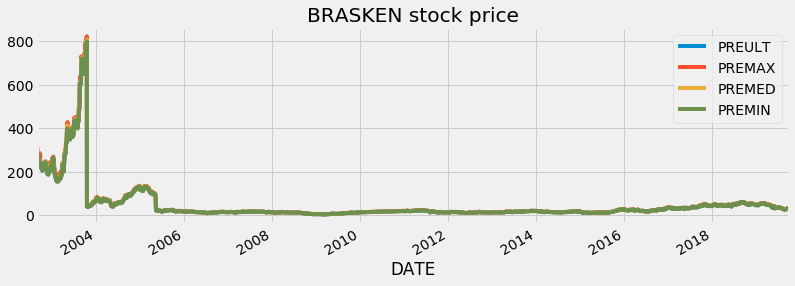

In [0]:
df_filtrado["PREULT"][:].plot(figsize=(12,4),legend=True)
df_filtrado["PREMAX"][:].plot(legend=True)
df_filtrado["PREMED"][:].plot(legend=True)
df_filtrado["PREMIN"][:].plot(legend=True)
plt.legend(['PREULT','PREMAX','PREMED','PREMIN'])
plt.title('BRASKEN stock price')
plt.show()

In [0]:
#Separando treino de teste
training_set = df_filtrado[:'2017'].loc[:,'PREULT'].values
test_set = df_filtrado['2018':'2019'].loc[:,'PREULT'].values
val_set = df_filtrado['2019':].loc[:,'PREULT'].values

In [0]:
#Normalizar os dados
sc = MinMaxScaler(feature_range=(0,1))
training_set = training_set.reshape(-1,1)
test_set = test_set.reshape(-1,1)
training_set_norm = sc.fit_transform(training_set)
test_set_norm = sc.fit_transform(test_set)

In [0]:
training_set_norm.shape

(3542, 1)

In [0]:
X_train = []
y_train = []
n_steps = 200
for i in range (n_steps, training_set_norm.shape[0]):
  X_train.append( training_set_norm[ i-n_steps:i, 0 ] )
  y_train.append( training_set_norm[ i, 0 ])
X_train, y_train = np.array(X_train), np.array(y_train)

In [0]:
y_train.shape

(3342,)

In [0]:
#Reshaping os valores de X
X_train_3D = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [0]:
X_train_3D.shape

(3342, 200, 1)

X_train( n samples, n steps, n features )

In [0]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=10, return_sequences=True, input_shape=(X_train_3D.shape[1], 1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=10, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=10, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=10))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error',metrics=['mse','mae'])
# Fitting to the training set
historico = regressor.fit(X_train_3D,y_train,epochs=50,batch_size=32)

DropOut - Retira x% dos numeros de neuronios para nao viciar os pessos.

Return sequences apenas de rede recorrente para rede recorrente.

Optimizer mais usados - rmsprop e xxxxxxx

In [0]:
historico.history.keys()

dict_keys(['loss', 'mse', 'mae'])

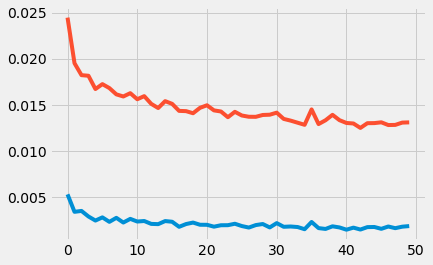

In [0]:
plt.plot( historico.history['mse'] )
plt.plot( historico.history['mae'] )

Dicas sobre a convergencia do algoritimo.

Learning Rate; Decaimento; numero de epocas

In [0]:
#Vamos testar com os dados de teste, lembrando que os valores de testes são também os resultados
#Para a primeira previsão com os dados de teste precisamos pegar 60 valores anteriores, só que para isso precisamos de todo dataset
dataset_total = pd.concat((df_filtrado['PREULT'][:'2017'],df_filtrado['PREULT']['2018':'2019']),axis=0)
inputs = dataset_total[ len(dataset_total)-len(test_set) - n_steps: ].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [0]:
#Preparando X de teste para prever as ações
X_test = []
for i in range(n_steps,inputs.shape[0]):
    X_test.append( inputs[ i-n_steps:i, 0 ] )
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [0]:
predicted_stock_price = regressor.predict(X_test)

In [0]:
predicted_stock_price[:10]

array([[0.485899  ],
       [0.4844422 ],
       [0.48426634],
       [0.48560247],
       [0.49034208],
       [0.49873346],
       [0.5102679 ],
       [0.5228974 ],
       [0.5360266 ],
       [0.5490651 ]], dtype=float32)

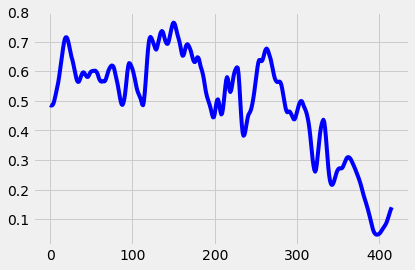

In [0]:
plt.plot(predicted_stock_price, color='blue',label='Predicted BRASKEN Stock Price')

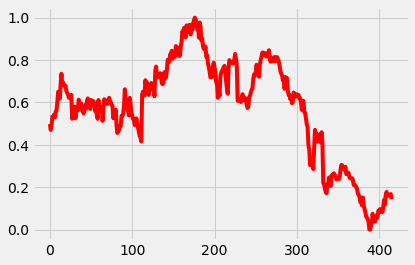

In [0]:
plt.plot(test_set_norm, color='red',label='Real BRASKEN Stock Price')

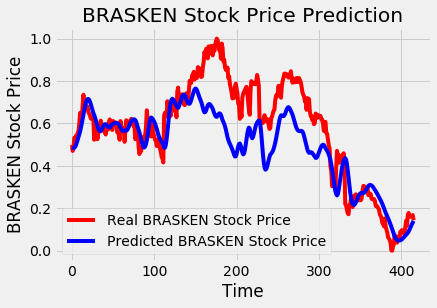

In [0]:
plt.plot(test_set_norm, color='red',label='Real BRASKEN Stock Price')
plt.plot(predicted_stock_price, color='blue',label='Predicted BRASKEN Stock Price')
plt.title('BRASKEN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('BRASKEN Stock Price')
plt.legend()
plt.show()

In [0]:
#Separando treino de teste
training_set = df_filtrado[:'2017'].loc[:,'PREMED'].values
test_set = df_filtrado['2018':'2019'].loc[:,'PREMED'].values
val_set = df_filtrado['2019':].loc[:,'PREMED'].values

In [0]:
#Normalizar os dados
sc = MinMaxScaler(feature_range=(0,1))
training_set = training_set.reshape(-1,1)
test_set = test_set.reshape(-1,1)
training_set_norm = sc.fit_transform(training_set)
test_set_norm = sc.fit_transform(test_set)

In [0]:
training_set_norm.shape

(3542, 1)

In [0]:
X_train = []
y_train = []
n_steps = 30
for i in range (n_steps, training_set_norm.shape[0]):
  X_train.append( training_set_norm[ i-n_steps:i, 0 ] )
  y_train.append( training_set_norm[ i, 0 ])
X_train, y_train = np.array(X_train), np.array(y_train)

In [0]:
y_train.shape

(3512,)

In [0]:
#Reshaping os valores de X
X_train_3D = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [0]:
X_train_3D.shape

(3512, 30, 1)

In [0]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=10, return_sequences=True, input_shape=(X_train_3D.shape[1], 1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=10, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=10, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=10))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error',metrics=['mse','mae'])
# Fitting to the training set
historico = regressor.fit(X_train_3D,y_train,epochs=100,batch_size=32)

Train on 3512 samples
Epoch 1/100
3512/3512 [==============================] - 7s 2ms/sample - loss: 0.0062 - mse: 0.0062 - mae: 0.0305
Epoch 2/100
3512/3512 [==============================] - 1s 396us/sample - loss: 0.0041 - mse: 0.0041 - mae: 0.0242
Epoch 3/100
3512/3512 [==============================] - 1s 388us/sample - loss: 0.0040 - mse: 0.0040 - mae: 0.0227
Epoch 4/100
3512/3512 [==============================] - 1s 394us/sample - loss: 0.0033 - mse: 0.0033 - mae: 0.0223
Epoch 5/100
3512/3512 [==============================] - 1s 384us/sample - loss: 0.0037 - mse: 0.0037 - mae: 0.0229
Epoch 6/100
3512/3512 [==============================] - 1s 382us/sample - loss: 0.0028 - mse: 0.0028 - mae: 0.0208
Epoch 7/100
3512/3512 [==============================] - 1s 386us/sample - loss: 0.0034 - mse: 0.0034 - mae: 0.0216
Epoch 8/100
3512/3512 [==============================] - 1s 390us/sample - loss: 0.0029 - mse: 0.0029 - mae: 0.0209
Epoch 9/100
3512/3512 [=============================

In [0]:
historico.history.keys()

dict_keys(['loss', 'mse', 'mae'])

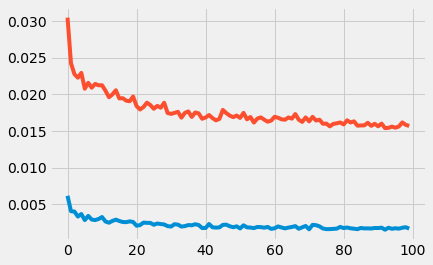

In [0]:
plt.plot( historico.history['mse'] )
plt.plot( historico.history['mae'] )

In [0]:
#Vamos testar com os dados de teste, lembrando que os valores de testes são também os resultados
#Para a primeira previsão com os dados de teste precisamos pegar 60 valores anteriores, só que para isso precisamos de todo dataset
dataset_total = pd.concat((df_filtrado['PREULT'][:'2017'],df_filtrado['PREULT']['2018':'2019']),axis=0)
inputs = dataset_total[ len(dataset_total)-len(test_set) - n_steps: ].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [0]:
#Preparando X de teste para prever as ações
X_test = []
for i in range(n_steps,inputs.shape[0]):
    X_test.append( inputs[ i-n_steps:i, 0 ] )
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [0]:
predicted_stock_price = regressor.predict(X_test)

In [0]:
predicted_stock_price[:10]

array([[0.5104406 ],
       [0.5157979 ],
       [0.5178321 ],
       [0.5189084 ],
       [0.52739   ],
       [0.5416356 ],
       [0.5573963 ],
       [0.567464  ],
       [0.57457477],
       [0.58120424]], dtype=float32)

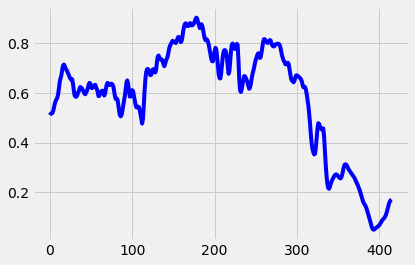

In [0]:
plt.plot(predicted_stock_price, color='blue',label='Predicted BRASKEN Stock Price')

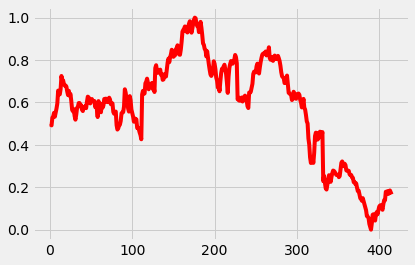

In [0]:
plt.plot(test_set_norm, color='red',label='Real BRASKEN Stock Price')

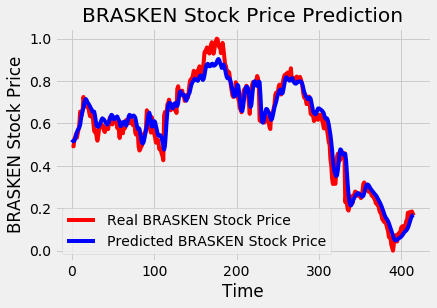

In [0]:
plt.plot(test_set_norm, color='red',label='Real BRASKEN Stock Price')
plt.plot(predicted_stock_price, color='blue',label='Predicted BRASKEN Stock Price')
plt.title('BRASKEN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('BRASKEN Stock Price')
plt.legend()
plt.show()

In [0]:
#Separando treino de teste
training_set = df_filtrado[:'2017'].loc[:,'PREMED'].values
test_set = df_filtrado['2018':'2019'].loc[:,'PREMED'].values
val_set = df_filtrado['2019':].loc[:,'PREMED'].values

In [0]:
#Normalizar os dados
sc = MinMaxScaler(feature_range=(0,1))
training_set = training_set.reshape(-1,1)
test_set = test_set.reshape(-1,1)
training_set_norm = sc.fit_transform(training_set)
test_set_norm = sc.fit_transform(test_set)

In [0]:
training_set_norm.shape

(3542, 1)

In [0]:
X_train = []
y_train = []
n_steps = 30
step = 5
for i in range (n_steps, training_set_norm.shape[0] - step ):
  X_train.append( training_set_norm[ i-n_steps:i, 0 ] )
  y_train.append( training_set_norm[ i:(i + step), 0 ])
X_train, y_train = np.array(X_train), np.array(y_train)

In [0]:
y_train.shape

(3507, 5)

In [0]:
#Reshaping os valores de X
X_train_3D = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [0]:
X_train_3D.shape

(3507, 30, 1)

In [0]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=10, return_sequences=True, input_shape=(X_train_3D.shape[1], 1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=10, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=10, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=10))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=5))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error',metrics=['mse','mae'])
# Fitting to the training set
historico = regressor.fit(X_train_3D,y_train,epochs=100,batch_size=32)

In [0]:
historico.history.keys()

dict_keys(['loss', 'mse', 'mae'])

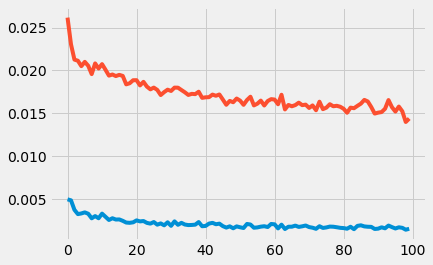

In [0]:
plt.plot( historico.history['mse'] )
plt.plot( historico.history['mae'] )

In [0]:
#Vamos testar com os dados de teste, lembrando que os valores de testes são também os resultados
#Para a primeira previsão com os dados de teste precisamos pegar 60 valores anteriores, só que para isso precisamos de todo dataset
dataset_total = pd.concat((df_filtrado['PREULT'][:'2017'],df_filtrado['PREULT']['2018':'2019']),axis=0)
inputs = dataset_total[ len(dataset_total)-len(test_set) - n_steps: ].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [0]:
#Preparando X de teste para prever as ações
X_test = []
for i in range(n_steps,inputs.shape[0]):
    X_test.append( inputs[ i-n_steps:i, 0 ] )
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [0]:
predicted_stock_price = regressor.predict(X_test)

In [0]:
predicted_stock_price[:10]

array([[0.5479088 ],
       [0.5530802 ],
       [0.55480707],
       [0.5557176 ],
       [0.5644367 ],
       [0.57946366],
       [0.596479  ],
       [0.6080088 ],
       [0.61639225],
       [0.6240183 ]], dtype=float32)

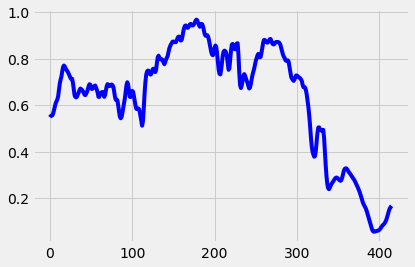

In [0]:
plt.plot(predicted_stock_price, color='blue',label='Predicted BRASKEN Stock Price')

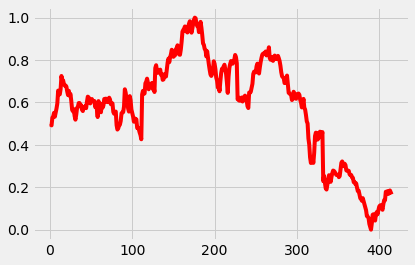

In [0]:
plt.plot(test_set_norm, color='red',label='Real BRASKEN Stock Price')

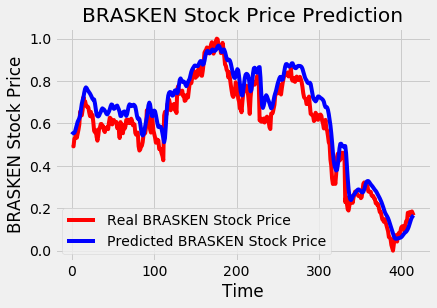

In [0]:
plt.plot(test_set_norm, color='red',label='Real BRASKEN Stock Price')
plt.plot(predicted_stock_price, color='blue',label='Predicted BRASKEN Stock Price')
plt.title('BRASKEN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('BRASKEN Stock Price')
plt.legend()
plt.show()